## Подготовка данных

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
import lightgbm as lgb
import matplotlib.pyplot as plt
!pip install catboost
from catboost import CatBoostRegressor, Pool

In [ ]:
data = pd.read_csv("autos.csv")

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [ ]:
display(data)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [ ]:
total = data.isnull().sum().sort_values(ascending = False)
percent = (data.isnull().sum() / data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis = 1, keys = ['Количество пропусков', 'Доля в %'])
missing_data['Тип данных признака'] = data.dtypes
display (missing_data)

,Количество пропусков,Доля в %,Тип данных признака
NotRepaired,71154,0.200791,object
VehicleType,37490,0.105794,object
FuelType,32895,0.092827,object
Gearbox,19833,0.055967,object
Model,19705,0.055606,object
LastSeen,0,0.000000,object
PostalCode,0,0.000000,int64
NumberOfPictures,0,0.000000,int64
DateCreated,0,0.000000,object
Brand,0,0.000000,object


Чтобы не удалять значительную часть данных - введём дополнительное обозначение. Скорее всего данные просто не были введены - так и запишем

In [ ]:
data["VehicleType"] = data["VehicleType"].fillna("not_designate")
data["Gearbox"] = data["Gearbox"].fillna("not_designate")
data["Model"] = data["Model"].fillna("not_designate")
data["FuelType"] = data["FuelType"].fillna("not_designate")

data["NotRepaired"] = data["NotRepaired"].fillna("no")


Надо понять дублируют друг друга значения категориальных признаков

In [ ]:
objects_columns = ["VehicleType","Gearbox","Model","FuelType","Brand","NotRepaired"]
for column in objects_columns:
    print(column, pd.Series(data[column].unique()).str.lower().duplicated().sum())

VehicleType 0
Gearbox 0
Model 0
FuelType 0
Brand 0
NotRepaired 0


Проверим на дубликаты

In [ ]:
data.duplicated().sum()

5

In [ ]:
data = data.drop_duplicates()
data.duplicated().sum()

0

Посмотрим на статистику

In [ ]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354364.000000,354364.000000,354364.000000,354364.000000,354364.000000,354364.0,354364.000000
mean,4416.655608,2004.234471,110.093723,128211.373051,5.714641,0.0,50508.461698
std,4514.159690,90.228593,189.851590,37905.136957,3.726433,0.0,25783.124276
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49409.500000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Удалим ненужные столбцы

In [ ]:
data_with_date = data.copy()
data = data.drop(["DateCrawled","DateCreated","LastSeen","NumberOfPictures","PostalCode"],axis = 1)

- В столбце - RegistrationMonth, минимальное значение 0, его можно заменить на первый месяц
- Очень нехорошо, что станд отклона в Price такая большая, алгоритму это не на пользу 
- Для столбца RegistrationYear установим границы, в котором может находится значение этого столбца, например с 1945 по 2021
- Для столбца Power установим гралицу л.с. по мощности спорткаров - 2100
Так же проанализируем значения в остальных столбцах.


Мы видим, что в столбцах присутствуют выбросы. Установим адекватные границы для признаков

In [ ]:

def RegistrationYear_2(value):
    if value > 2021:
        return 2021
    elif value < 1945:
        return 1945
    else:
        return value
data["RegistrationYear"] = data["RegistrationYear"].apply(RegistrationYear_2)

data.loc[data['RegistrationMonth'] == 0, 'RegistrationMonth'] = 1

data.loc[data['Power'] > 2100, 'Power'] = 2100

In [ ]:
def anomali_cut(data,column):
    quantile_25=np.array(data[column].quantile(0.25))
    
    quantile_75=np.array(data[column].quantile(0.75))
    first=quantile_25-1.5*(quantile_75-quantile_25)
    second=quantile_75+1.5*(quantile_75-quantile_25)
    del_index = []
    for index_value, value in zip(data[column].index,data[column]):
        if second <= value or value <= first:
            del_index.append(index_value)
    
    print('Количество строк, выбранных для удаления ' + str(column)+":",len(del_index))
    return del_index

In [ ]:
pp = ["Price","Power"]
count = 0 
for column in pp:
    index_del = anomali_cut(data,column)
    count += len(index_del)
    data = data.drop(index_del,axis = 0)
print("Было удалено:", count)

Количество строк, выбранных для удаления Price: 18979
Количество строк, выбранных для удаления Power: 5153
Было удалено: 24132


In [ ]:
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,not_designate,1993,manual,0,golf,150000,1,petrol,volkswagen,no
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes


In [ ]:
data.corr()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
Price,1.000000,0.368572,0.433664,-0.279190,0.108351
RegistrationYear,0.368572,1.000000,0.091125,-0.136613,0.041293
Power,0.433664,0.091125,1.000000,0.134619,0.125639
Kilometer,-0.279190,-0.136613,0.134619,1.000000,0.015735
RegistrationMonth,0.108351,0.041293,0.125639,0.015735,1.000000


### Выводы

- Данные были загрязнены сильно отклоняющимися значениями. Мы их почистили и посмотрим, на сколько это повлияет на работу модели.
- Проверена корреляция: все в рамках разумных пределов, наиболее коррелирующим с целевым признаком является признак отвечающий за мощность
- Удалены дубликаты и пропущенные значения заменены на наиболее часто встречающиеся у себя в столбце, так как простое удаление так же привело бы к большой потере данных.

Закодируем выборки

In [ ]:
data_1 = data.copy()
data_1 = pd.get_dummies(data_1, drop_first=True)
data_cl = data.copy()
data_cl = data_cl.astype({"VehicleType":'category',
                                  "Gearbox":'category',
                                  "Model":'category',
                                  "FuelType":'category',
                                  "Brand":'category',
                                  "NotRepaired":'category'})




Разделим данные на выборки

In [ ]:
train_f,test_f,train_s,test_s = train_test_split(data_1.drop("Price",axis = 1),
                                             data_1["Price"],
                                             test_size = 0.25,
                                             random_state = 12342)

train_f1,test_f1,train_s1,test_s1 = train_test_split(data.drop("Price",axis = 1),
                                             data["Price"],
                                             test_size = 0.25,
                                             random_state = 12342)
(train_f1_cl,
 test_f1_cl,
 train_s1_cl,
 test_s1_cl) = train_test_split(data_cl.drop("Price",axis = 1),
                                             data_cl["Price"],
                                             test_size = 0.25,
                                             random_state = 12342)


Добавим ОЕ кодировку для случайного леса

In [ ]:
data_oe = data.copy()

encoder = OrdinalEncoder()

data_oe = pd.DataFrame(encoder.fit_transform(data_oe),
                            columns=data_oe.columns)

f_columns =["VehicleType","Gearbox", "Model","FuelType","Brand","NotRepaired"]
f_features = data_oe[f_columns]
f_features = pd.DataFrame(encoder.fit_transform(f_features),
                                columns=f_features.columns, 
                                index=f_features.index)
ordinal_features = data_oe.copy()
for column in f_columns:
    ordinal_features[column] = f_features[column]

     
(train_zoe,
test_zoe, train_poe,
test_poe) = train_test_split(ordinal_features.drop("Price",axis = 1),
                                            ordinal_features["Price"],
                                            test_size = 0.25,
                                            random_state = 12342)

## Обучение моделей

In [ ]:
%%time

catboost = CatBoostRegressor(loss_function='RMSE')
parameters_cat = {'depth':[5,10], 'learning_rate':np.arange(0.1,1,0.2)}
catboost_grid = catboost.grid_search(parameters_cat,
            Pool(train_f1, train_s1, cat_features=["VehicleType","Gearbox",
                                                             "Model","FuelType",
                                                             "Brand","NotRepaired"]),
            cv=3,
            verbose=True,
            plot=False)

Выходные данные были обрезаны до нескольких последних строк (5000).
23:	learn: 1490.6355526	test: 1516.9448154	best: 1516.9448154 (23)	total: 9.83s	remaining: 6m 39s
24:	learn: 1485.4405611	test: 1513.4095445	best: 1513.4095445 (24)	total: 10.3s	remaining: 6m 40s
25:	learn: 1481.5870980	test: 1510.3489679	best: 1510.3489679 (25)	total: 10.6s	remaining: 6m 37s
26:	learn: 1477.7581581	test: 1508.2025415	best: 1508.2025415 (26)	total: 11.1s	remaining: 6m 38s
27:	learn: 1475.3824423	test: 1506.3451058	best: 1506.3451058 (27)	total: 11.5s	remaining: 6m 40s
28:	learn: 1473.2951364	test: 1505.9219879	best: 1505.9219879 (28)	total: 12s	remaining: 6m 40s
29:	learn: 1469.5955278	test: 1504.4830872	best: 1504.4830872 (29)	total: 12.4s	remaining: 6m 40s
30:	learn: 1464.2193369	test: 1500.3577815	best: 1500.3577815 (30)	total: 12.7s	remaining: 6m 38s
31:	learn: 1460.8535341	test: 1498.2615497	best: 1498.2615497 (31)	total: 13.3s	remaining: 6m 41s
32:	learn: 1458.2201257	test: 1496.1828832	best: 149

In [ ]:
catboost_grid["params"]


{'depth': 10, 'learning_rate': 0.1}

Проведем эксперимент с моделью случайного леса на признаках, закодированных по методу OE и OHE


In [ ]:
%%time
regressor = RandomForestRegressor() 
hyperparams = [{'criterion':['mse'], 
                'max_depth':[5,20],
                'n_estimators':[20,100],  
                'random_state':[12345]}]

clf = GridSearchCV(estimator=regressor, param_grid=hyperparams, scoring='neg_mean_squared_error',verbose=True)
clf.fit(train_zoe, train_poe)
print("Лучший параметр:")
print()
print(clf.best_params_)
print()
print("MSE:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

RMSE_DTR_ordinal = (max(means)*-1) ** 0.5

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  8.6min finished


Лучший параметр:

{'criterion': 'mse', 'max_depth': 20, 'n_estimators': 100, 'random_state': 12345}

MSE:

486.488991 for {'criterion': 'mse', 'max_depth': 5, 'n_estimators': 20, 'random_state': 12345}
486.751017 for {'criterion': 'mse', 'max_depth': 5, 'n_estimators': 100, 'random_state': 12345}
365.971515 for {'criterion': 'mse', 'max_depth': 20, 'n_estimators': 20, 'random_state': 12345}
361.254286 for {'criterion': 'mse', 'max_depth': 20, 'n_estimators': 100, 'random_state': 12345}

CPU times: user 9min 56s, sys: 2.29 s, total: 9min 58s
Wall time: 9min 55s


In [ ]:
%%time

regressor = RandomForestRegressor() 
hyperparams = [{'criterion':['mse'], 
                'max_depth':[5,20],
                'n_estimators':[20,100],  
                'random_state':[12345]}]

clf = GridSearchCV(estimator=regressor, param_grid=hyperparams, scoring='neg_mean_squared_error',verbose=True)
clf.fit(train_f, train_s)
print("Лучший параметр:")
print()
print(clf.best_params_)
print()
print("Оценки:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

RMSE_DTR_ohe = (max(means)*-1) ** 0.5

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 57.3min finished


Лучший параметр:

{'criterion': 'mse', 'max_depth': 20, 'n_estimators': 100, 'random_state': 12345}

Оценки:

2028.544889 for {'criterion': 'mse', 'max_depth': 5, 'n_estimators': 20, 'random_state': 12345}
2019.986528 for {'criterion': 'mse', 'max_depth': 5, 'n_estimators': 100, 'random_state': 12345}
1482.965809 for {'criterion': 'mse', 'max_depth': 20, 'n_estimators': 20, 'random_state': 12345}
1467.644715 for {'criterion': 'mse', 'max_depth': 20, 'n_estimators': 100, 'random_state': 12345}

CPU times: user 1h 6min 26s, sys: 5.04 s, total: 1h 6min 31s
Wall time: 1h 6min 10s


Проверим время обучения с найденными параметрами для каждой модели

In [ ]:
%%time
catbost = CatBoostRegressor(depth=catboost_grid["params"]["depth"], 
                              learning_rate=catboost_grid["params"]['learning_rate'],
                              loss_function='RMSE',verbose=100)
catbost.fit(Pool(train_f1,train_s1,
                   cat_features=["VehicleType","Gearbox","Model","FuelType","Brand","NotRepaired"]))

0:	learn: 3202.5177053	total: 473ms	remaining: 7m 52s
100:	learn: 1447.2114771	total: 46.1s	remaining: 6m 49s
200:	learn: 1378.8612137	total: 1m 31s	remaining: 6m 4s
300:	learn: 1341.4200804	total: 2m 18s	remaining: 5m 21s
400:	learn: 1313.2500970	total: 3m 5s	remaining: 4m 36s
500:	learn: 1289.0113052	total: 3m 52s	remaining: 3m 51s
600:	learn: 1268.3029082	total: 4m 40s	remaining: 3m 6s
700:	learn: 1250.7879927	total: 5m 29s	remaining: 2m 20s
800:	learn: 1234.6608524	total: 6m 20s	remaining: 1m 34s
900:	learn: 1218.6872875	total: 7m 10s	remaining: 47.4s
999:	learn: 1203.8583819	total: 8m	remaining: 0us
CPU times: user 15min 32s, sys: 10.3 s, total: 15min 42s
Wall time: 8min 4s


In [ ]:
%%time

forest = RandomForestRegressor(criterion = "mse",random_state=42, n_estimators = 100,n_jobs=-1)
forest.fit(train_f,train_s)

CPU times: user 17min 56s, sys: 1.39 s, total: 17min 58s
Wall time: 9min 7s


In [ ]:
%%time

train_X = lgb.Dataset(train_f1_cl, train_s1_cl)
test_X = lgb.Dataset(test_f1_cl, test_s1_cl, reference=train_X)
parameters_lgb = {'metric': 'l2', 'max_depth':10,"random_state": 42,"learning_rate":0.1}
lightgb = lgb.train(parameters_lgb,
                train_X,
                num_boost_round=1000,
                valid_sets=[train_X, test_X],
                verbose_eval=100)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[100]	training's l2: 2.02789e+06	valid_1's l2: 2.0921e+06
[200]	training's l2: 1.89503e+06	valid_1's l2: 2.02161e+06
[300]	training's l2: 1.81404e+06	valid_1's l2: 1.98802e+06
[400]	training's l2: 1.75353e+06	valid_1's l2: 1.96729e+06
[500]	training's l2: 1.6973e+06	valid_1's l2: 1.94912e+06
[600]	training's l2: 1.65599e+06	valid_1's l2: 1.93761e+06
[700]	training's l2: 1.62129e+06	valid_1's l2: 1.92835e+06
[800]	training's l2: 1.58853e+06	valid_1's l2: 1.92112e+06
[900]	training's l2: 1.56155e+06	valid_1's l2: 1.91776e+06
[1000]	training's l2: 1.53449e+06	valid_1's l2: 1.91277e+06
CPU times: user 26.1 s, sys: 253 ms, total: 26.4 s
Wall time: 13.5 s



Посчитаем ошибку для каждой модели и определим время предсказаний

In [ ]:

%%time
print("CatBoost:",mean_squared_error(test_s,catbost.predict(test_f1),squared=False))

CatBoost: 1388.9395863891154
CPU times: user 2.71 s, sys: 27.9 ms, total: 2.74 s
Wall time: 1.47 s


In [ ]:
%%time
print("RandomForest:",mean_squared_error(test_s,forest.predict(test_f),squared=False))

RandomForest: 1426.2616915554145
CPU times: user 6.99 s, sys: 23.5 ms, total: 7.02 s
Wall time: 3.74 s


In [ ]:
%%time
print("LightGBM:",(mean_squared_error(test_s,lightgb.predict(test_f1_cl),squared=False)))


LightGBM: 1383.0297001304014
CPU times: user 7.05 s, sys: 12.6 ms, total: 7.06 s
Wall time: 3.65 s


Посмотрим на график важности факторов

CatBoost:


,Feature Id,Importances
0,RegistrationYear,29.842087
1,Power,16.709581
2,VehicleType,16.032595
3,Brand,12.898923
4,Kilometer,8.659073
5,Model,6.428151
6,FuelType,3.137651
7,NotRepaired,2.440651
8,Gearbox,1.940242
9,RegistrationMonth,1.911046


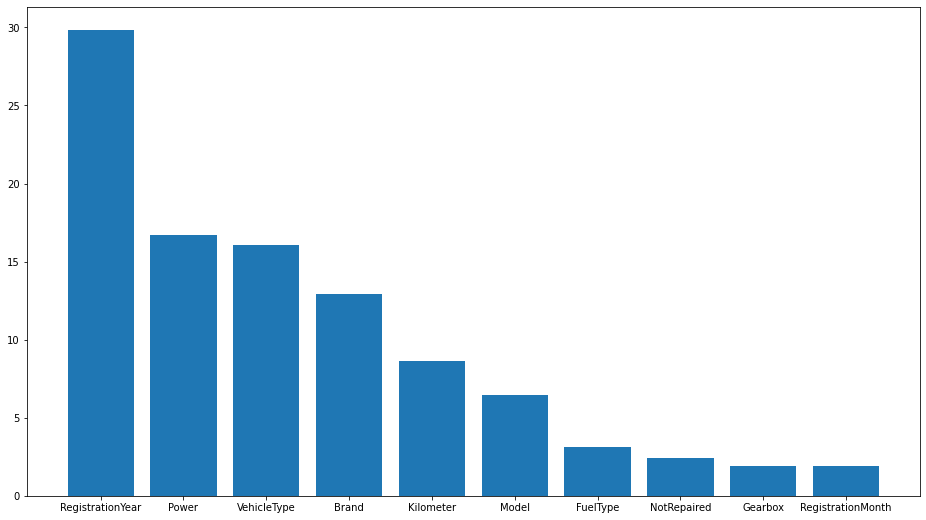

In [ ]:
print("CatBoost:")

train_dataset = Pool(train_f1, train_s1, cat_features=["VehicleType","Gearbox",
                                                             "Model","FuelType",
                                                             "Brand","NotRepaired"])
plt.figure(figsize=(16,9))
importance_cat = catbost.get_feature_importance(train_dataset, prettified = True)
plt.bar(importance_cat['Feature Id'],importance_cat['Importances'])
importance_cat

LightGBM:


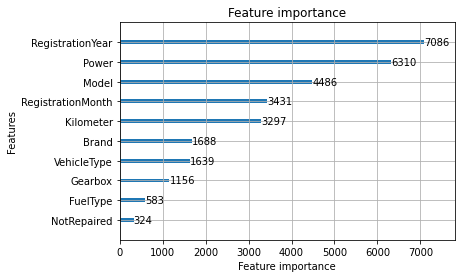

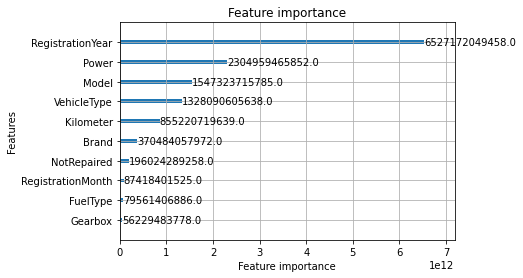

In [ ]:
print("LightGBM:")
lgb.plot_importance(lightgb, importance_type = 'split');
lgb.plot_importance(lightgb, importance_type = 'gain');



## Анализ моделей

In [ ]:
index = ['RandomForest',
         'CatBoostRegressor',
         'LightGBM']
frame = {'RMSE':[1426,
                 1388,
                 1383],
        'Время обучения на CV, сек':[547,
                                     484,
                                     13.5],

        'Время предсказания модели, сек':[3.74,
                                          1.47,
                                          3.65]}

scores_data = pd.DataFrame(data=frame, index=index)
display(scores_data)

,RMSE,"Время обучения на CV, сек","Время предсказания модели, сек"
RandomForest,1426,547.0,3.74
CatBoostRegressor,1388,484.0,1.47
LightGBM,1383,13.5,3.65


Модели добились хороших результатов по скорости и rmse, в каждой метрике есть свои лидеры. По скорости предсказания –  CatBoost; по скорости обучения – LightGBM; rmse – LightGBM. Если по rmse и скорости предсказания модели где-то рядом, то перевес в сторону LightGBM начинается на скорости обучения.

Сравнивая результаты OHE и ОЕ случайного леса, можно сказать, что обучение с кодировкой ОЕ проходит гораздо быстрее.

Для данного проекта лучшей моделью будет являться LightGBM с глубиной в 10.